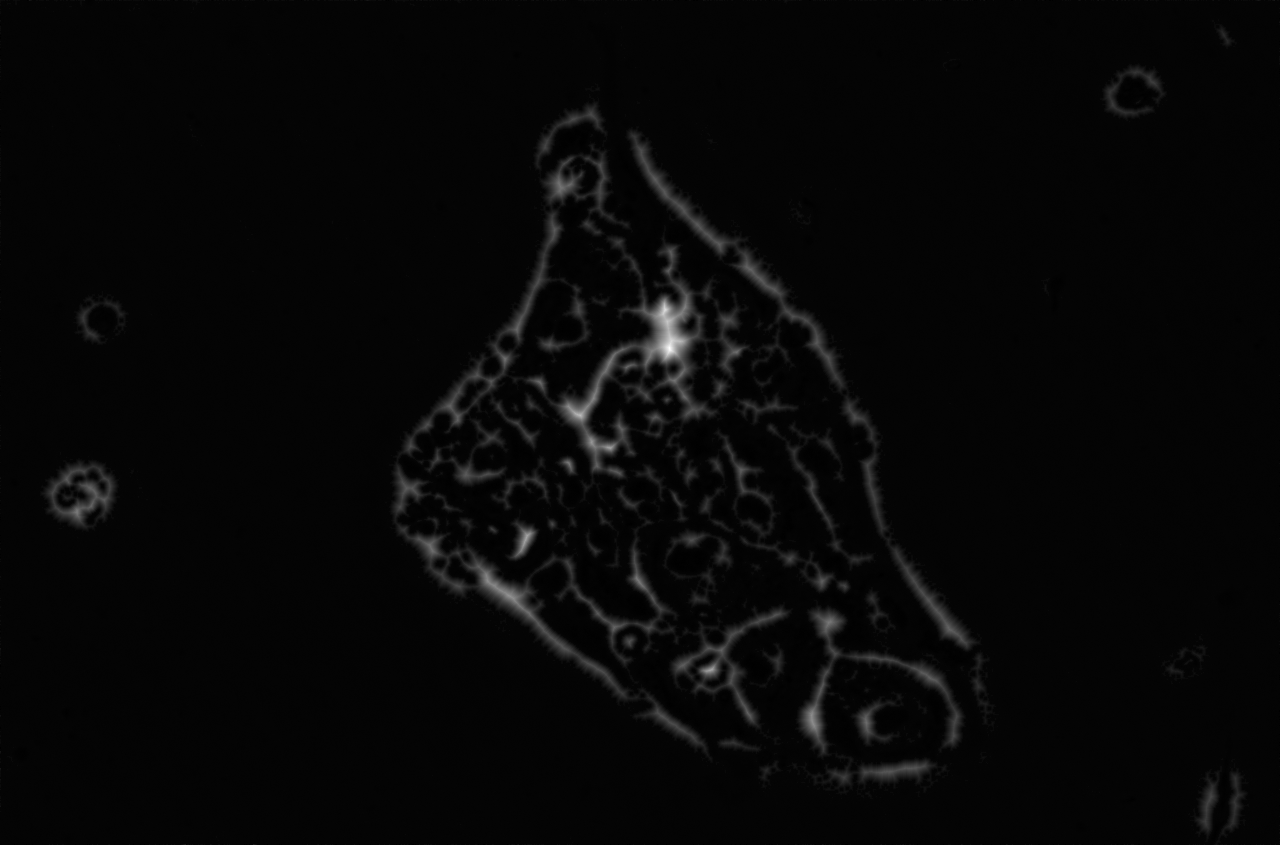

In [ ]:
import cv2
import numpy as np
import heapq

# Try importing cv2_imshow for Google Colab; otherwise, use cv2.imshow for a normal environment
try:
    from google.colab.patches import cv2_imshow  # For Colab
except ImportError:
    cv2_imshow = cv2.imshow  # For regular Python environments

# Define constants
INF = np.finfo(np.float32).max  # A large value representing infinite distance
ALIVE, TRIAL, FAR = -1, 0, 1  # States for pixels in the distance transform

def initialize_gwdt(image):
    """Initialize state and distance maps based on image intensity."""
    rows, cols = image.shape
    mean_val = np.mean(image)  # Compute mean intensity of the image

    # Initialize state map (default FAR) and distance map (default INF)
    state = np.full((rows, cols), FAR, dtype=np.int8)
    distance_map = np.full((rows, cols), INF, dtype=np.float32)

    # Identify foreground pixels (below mean intensity) as ALIVE and set initial distances
    mask = image < mean_val
    distance_map[mask] = image[mask].astype(float)
    state[mask] = ALIVE

    return state, distance_map

def compute_gwdt(image):
    """Compute the Grey Weighted Distance Transform (GWDT)."""
    rows, cols = image.shape
    state, distance_map = initialize_gwdt(image)  # Initialize state and distance maps
    pq = []  # Priority queue for processing pixels

    # Identify border pixels adjacent to ALIVE pixels and initialize them as TRIAL
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if state[i, j] == FAR:
                if np.any(state[i-1:i+2, j-1:j+2] == ALIVE):  # Check if any neighbor is ALIVE
                    state[i, j] = TRIAL
                    distance_map[i, j] = float(image[i, j])  # Set initial distance
                    heapq.heappush(pq, (distance_map[i, j], i, j))  # Add to priority queue

    # Process pixels in priority queue
    while pq:
        current_dist, i, j = heapq.heappop(pq)  # Extract pixel with smallest distance

        # Iterate over 8-connected neighborhood
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols:  # Ensure the pixel is within bounds
                gs = current_dist + image[ni, nj] * np.hypot(di, dj)  # Compute weighted distance

                if distance_map[ni, nj] > gs:  # Update distance if a shorter path is found
                    distance_map[ni, nj] = gs
                    state[ni, nj] = TRIAL
                    heapq.heappush(pq, (gs, ni, nj))  # Add updated pixel to priority queue

    # Normalize distance values for visualization
    distance_map[distance_map == INF] = 0  # Replace INF values with 0
    max_val = np.max(distance_map)

    if max_val > 0:
        distance_map = (distance_map / (max_val + 1)) * 255  # Normalize to [0, 255]
    else:
        distance_map.fill(0)  # Handle case where all distances are zero

    return distance_map.astype(np.uint8)  # Convert to uint8 for image display

def apply_gwdt(input_path, output_path):
    """Apply GWDT to an image and save the result."""
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)  # Load input image as grayscale
    gwdt_result = compute_gwdt(image)  # Compute GWDT

    cv2.imwrite(output_path, gwdt_result)  # Save the output image
    cv2_imshow(gwdt_result)  # Display the result
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
if __name__ == '__main__':
    apply_gwdt("genimage.tif", "output_gwdt.tif")
